In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
import re
import numpy

import matplotlib.pyplot as plt

In [4]:
# From http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
# make things wide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()
        
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)
    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')
        #print(data)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))

Please note that the graph visualizations only work in Chrome :(

In [5]:
tf.reset_default_graph()

In [6]:
# Allocate inputs and outputs

# Placeholders are nodes in the graph whose values need to be 
# provded using feeds
#
# A note about shapes: unlike the Math convention (col-major)
# Python is row-major and everything we do will be transposed
X = tf.placeholder('float32', shape=(None, 2), name='X')
Y = tf.placeholder('float32', shape=(None, 1), name='Y')

In [7]:
def affine_layer(X, num_hidden, activation=None, name=None):
    name = name or "affine_layer"
    with tf.variable_scope(None, default_name=name):
        W = tf.get_variable('W', (X.shape[1].value, num_hidden), 'float32',
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', (1, num_hidden), 'float32',
                            initializer=tf.zeros_initializer())
        Y = tf.matmul(X, W) + b
        if activation:
            Y = activation(Y)
        return Y

In [8]:
Output = affine_layer(X, 10, tf.nn.relu)
Output = affine_layer(Output, 1)
Loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(Output, Y))

In [9]:
# show_graph()

In [10]:
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(Loss)
global_step = tf.get_variable('global_step', shape=(), dtype='int32', 
                              trainable=False)
train_op = tf.group(train_op, tf.assign_add(global_step, 1))

In [11]:
initialize_op = tf.global_variables_initializer()

In [12]:
sess = tf.InteractiveSession()

In [13]:
sess.run(initialize_op)

(-1.5, 1.5, -1.5, 1.5)

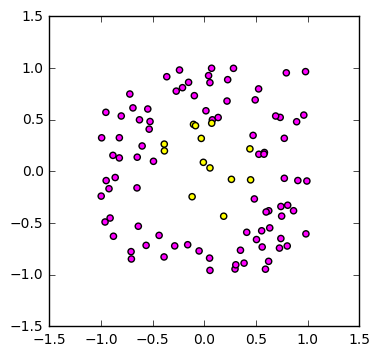

In [14]:
DataX = np.random.rand(100, 2)*2.0 - 1.0
DataY = np.sum((DataX**2), axis=1) < 0.5**2
DataY = np.reshape(DataY, (-1,1))

plt.scatter(DataX[:,0], DataX[:,1], c=DataY, cmap='spring')
plt.axis('square')

In [15]:
# train for a while

sess.run(initialize_op)

loss_history = []
use_batch=False

global_step_v = sess.run(global_step)
epoch = 0

while global_step_v < 100000:
    epoch += 1
    # Batch grad descent
    if use_batch:
        feed_dicts=[{X:DataX, Y:DataY}]
    else: # SGD
        data_shuffle = np.random.permutation(DataX.shape[0])
        feed_dicts = []
        batch_size = 10
        for batch_start in range(0, DataX.shape[0] - batch_size + 1, batch_size):
            batch_idx = data_shuffle[batch_start:batch_start+batch_size]
            feed_dicts.append({X:DataX[batch_idx], Y:DataY[batch_idx]})
    
    for feed_dict in feed_dicts:
        _, global_step_v, loss_v = sess.run([train_op, global_step, Loss], feed_dict=feed_dict)
        if (global_step_v % 1000) == 1:
            loss_history.append((epoch, global_step_v, loss_v,))
            print ("epoch: %d, step: %d, loss: %g" % (epoch, global_step_v, loss_v,))

epoch: 1, step: 1, loss: 0.738859
epoch: 101, step: 1001, loss: 0.387385
epoch: 201, step: 2001, loss: 0.194923
epoch: 301, step: 3001, loss: 0.130208
epoch: 401, step: 4001, loss: 0.283437
epoch: 501, step: 5001, loss: 0.175167
epoch: 601, step: 6001, loss: 0.25038
epoch: 701, step: 7001, loss: 0.010954
epoch: 801, step: 8001, loss: 0.128881
epoch: 901, step: 9001, loss: 0.0706301
epoch: 1001, step: 10001, loss: 0.135202
epoch: 1101, step: 11001, loss: 0.104901
epoch: 1201, step: 12001, loss: 0.162626
epoch: 1301, step: 13001, loss: 0.0747396
epoch: 1401, step: 14001, loss: 0.0175415
epoch: 1501, step: 15001, loss: 0.0387842
epoch: 1601, step: 16001, loss: 0.0550907
epoch: 1701, step: 17001, loss: 0.026703
epoch: 1801, step: 18001, loss: 0.122204
epoch: 1901, step: 19001, loss: 0.0205099
epoch: 2001, step: 20001, loss: 0.0602948
epoch: 2101, step: 21001, loss: 0.0255738
epoch: 2201, step: 22001, loss: 0.0315488
epoch: 2301, step: 23001, loss: 0.0119055
epoch: 2401, step: 24001, loss: 

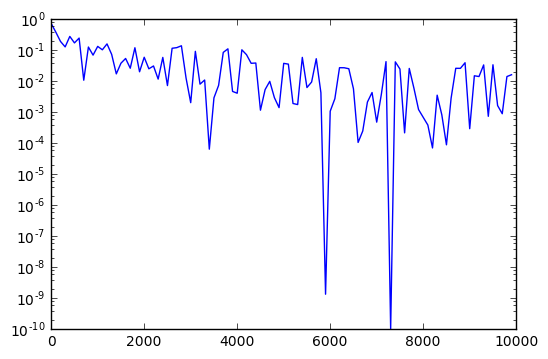

In [16]:
loss_history = np.array(loss_history)
plt.semilogy(loss_history[:,0], loss_history[:,2])

In [17]:
meshX = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
meshX = np.hstack([m.reshape(-1, 1) for m in meshX])

In [18]:
Output_v = sess.run(Output, feed_dict={X: meshX})

(-2.0, 2.0, -2.0, 2.0)

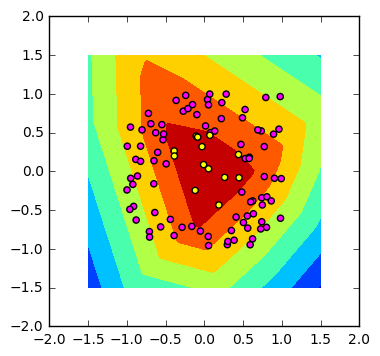

In [19]:
plt.contourf(meshX[:,0].reshape(100,100), meshX[:,1].reshape(100,100), Output_v.reshape(100,100))
plt.scatter(DataX[:,0], DataX[:,1], c=DataY, cmap='spring')
plt.axis('square')

In [20]:
# show_graph()

Network on MNIST

In [21]:
from fuel.datasets.mnist import MNIST
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

MNIST.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}))

mnist_train = MNIST(("train",), subset=slice(None,50000))
#this stream will shuffle the MNIST set and return us batches of 100 examples
mnist_train_stream = DataStream.default_stream(
    mnist_train,
    iteration_scheme=ShuffledScheme(mnist_train.num_examples, 25))
                                               
mnist_validation = MNIST(("train",), subset=slice(50000, None))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
mnist_validation_stream = DataStream.default_stream(
    mnist_validation, iteration_scheme=SequentialScheme(mnist_validation.num_examples, 100))
mnist_test = MNIST(("test",))
mnist_test_stream = DataStream.default_stream(
    mnist_test, iteration_scheme=SequentialScheme(mnist_test.num_examples, 100))

Couldn't import dot_parser, loading of dot files will not be possible.


In [22]:
print("The streams return batches containing %s" % (mnist_train_stream.sources,))

print("Each trainin batch consits of a tuple containing:")
for element in next(mnist_train_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))
    
print("Validation/test batches consits of tuples containing:")
for element in next(mnist_test_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (25, 1, 28, 28) containing float32
 - an array of size (25, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 1, 28, 28) containing float32
 - an array of size (100, 1) containing uint8


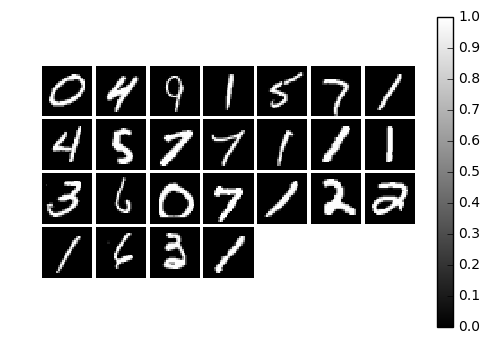

In [23]:
from common.plotting import plot_mat

mnist_X,mnist_Y= next(mnist_train_stream.get_epoch_iterator())

plot_mat(mnist_X, cmap='gray')
plt.colorbar()

In [24]:
def conv2d_layer(X, filter_shape, num_filters, activation=None, name=None):
    name = name or "conv2d_layer"
    num_channels = X.shape[3].value
    with tf.variable_scope(None, default_name=name):
        F = tf.get_variable('F', (filter_shape[0], filter_shape[1], num_channels, num_filters), 'float32',
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        b = tf.get_variable('b', (1, 1, 1, num_filters), 'float32',
                            initializer=tf.zeros_initializer())
        Y = tf.nn.conv2d(X, F, (1, 1, 1, 1), padding='VALID') + b
        if activation:
            Y = activation(Y)
        return Y

In [25]:
tf.reset_default_graph()

In [26]:
# X is batch_size x num_channels x width x heigth
X = tf.placeholder(shape=(None, 1, 28, 28), dtype=np.float32, name='X')
X_NHWC = tf.transpose(X, [0, 2, 3, 1])
Y = tf.placeholder(shape=(None, 1), dtype=np.int32, name='Y')

X_flat = tf.reshape(X, (-1, np.prod(X.shape.as_list()[1:])))

In [27]:
if 0:
    L = X_flat
else:
    L = X_NHWC
    print ("Input shape %s" % (L.shape,))
    for filter_size, num_filters in [(5, 10), (3, 25)]:
        L = conv2d_layer(L, (5, 5), num_filters, activation=tf.nn.relu)
        print ("After conv shape %s" % (L.shape,))
        L = tf.nn.max_pool(L, (1, 2, 2, 1), (1, 2, 2, 1), padding='VALID')
        L = tf.nn.dropout(L, keep_prob=0.8)
        print ("After pool shape %s" % (L.shape,))
    L = tf.reshape(L, (-1, np.prod(L.shape.as_list()[1:])))
    print ("After flattening %s" % (L.shape,))
    
for layer_dim in [400, 400]:
    L = affine_layer(L, layer_dim, activation=tf.nn.relu)
    print ("After affine %s" % (L.shape,))
    L = tf.nn.dropout(L, keep_prob=0.8)
L = affine_layer(L, 10)

per_example_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(L, tf.reshape(Y, (-1,)))
xentropy_loss = tf.reduce_mean(per_example_loss)

weight_decay_loss = 0.0
for V in tf.trainable_variables():
    if re.match(V.name, ".*/W.*"):
        weight_decay_loss += 1.0e-5 * tf.reduce_sum(V**2)


batch_loss = xentropy_loss + weight_decay_loss
classification = tf.argmax(L, axis=1)

Input shape (?, 28, 28, 1)
After conv shape (?, 24, 24, 10)
After pool shape (?, 12, 12, 10)
After conv shape (?, 8, 8, 25)
After pool shape (?, 4, 4, 25)
After flattening (?, 400)
After affine (?, 400)
After affine (?, 400)


In [28]:
learning_rate = tf.get_variable('learning_rate', shape=(), dtype='float32', 
                              trainable=False)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(batch_loss)
global_step = tf.get_variable('global_step', shape=(), dtype='int32', 
                              trainable=False)
train_op = tf.group(train_op, tf.assign_add(global_step, 1))
initialize_op = tf.global_variables_initializer()

In [29]:
# show_graph()

In [30]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(initialize_op)

train_loss_history = []
valid_loss_history = []
epoch = 0

In [31]:
sess.run(learning_rate.assign(1e-4))

9.9999997e-05

In [32]:
# train for a while
global_step_v = sess.run(global_step)

while global_step_v < 100000:
    epoch += 1
    for batch_X, batch_Y in mnist_train_stream.get_epoch_iterator():
        feed_dict = {X: batch_X, Y: batch_Y}
        _, global_step_v, loss_v = sess.run([train_op, global_step, batch_loss], feed_dict=feed_dict)
        if (global_step_v % 1000) == 1:
            loss_history.append((epoch, global_step_v, loss_v,))
            print ("epoch: %d, step: %d, loss: %g" % (epoch, global_step_v, loss_v,))
    
    test_stats = []
    for batch_X, batch_Y in mnist_validation_stream.get_epoch_iterator():
        feed_dict = {X: batch_X, Y: batch_Y}
        classification_v, batch_loss_v = sess.run([classification, batch_loss], feed_dict=feed_dict)
        batch_accuracy = np.mean(classification_v == batch_Y[:,0])
        test_stats.append((batch_accuracy, batch_loss_v)) 
    valid_acc, valid_batch_loss = np.mean(test_stats, axis=0)
    print ("epoch: %d, step: %d, valid_loss: %g, valid_acc: %f" % (epoch, global_step_v, valid_batch_loss, valid_acc))
    valid_loss_history.append((epoch, global_step_v, valid_batch_loss, valid_acc))
    

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
vars = {V.name: V for V in tf.trainable_variables()}
F1_v = sess.run(vars['conv2d_layer/F:0'])

In [ ]:
F1_v.shape

In [ ]:
plot_mat(F1_v.transpose(3, 2, 0, 1), cmap='gray')